## Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.
 
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [412]:
# import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max.columns',None)

In [413]:
# Read the data
telecom = pd.read_csv('telecom_churn_data.csv')
telecom.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

**Check structure of data**

In [414]:
telecom.shape

(99999, 226)

In [415]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [416]:
telecom.dtypes.value_counts()

float64    179
int64       35
object      12
dtype: int64

### Data Preparation and EDA

**Filter high-value customers**

Need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [417]:
# Let us check the percentage of missing value in Total recharge columns 6 and 7
print(telecom.total_rech_amt_6.isnull().sum())
print(telecom.total_rech_amt_7.isnull().sum())

0
0


In [418]:
# Create new column to store average recharge of 6 and 7 months
telecom['avg_total_recharge_6_7'] = round((telecom.total_rech_amt_6+telecom.total_rech_amt_7)/2)
telecom['avg_total_recharge_6_7'].head(15)

0      307.0
1      229.0
2      242.0
3      270.0
4      273.0
5       60.0
6      360.0
7     1185.0
8      519.0
9      208.0
10       0.0
11     183.0
12     110.0
13     380.0
14      50.0
Name: avg_total_recharge_6_7, dtype: float64

In [419]:
# Get the threshold amount for HVC
qualifying_amount = telecom['avg_total_recharge_6_7'].quantile(0.7)
print(qualifying_amount)

368.0


In [420]:
# Remove all rows having avg recharge amount less than qualifying amount
telecom_hvc = telecom.loc[telecom.avg_total_recharge_6_7 >= qualifying_amount,:]
telecom_hvc.shape

(30098, 227)

In [421]:
# Let us check the correlation between the average column and indivisual recharge month 
print(telecom.avg_total_recharge_6_7.corr(telecom.total_rech_amt_6))
print(telecom.avg_total_recharge_6_7.corr(telecom.total_rech_amt_7))

0.9179134157945578
0.9220926368412733


In [422]:
# We can see there is a very high correlation of the average column with the indivisual month (6,7) columns
# We will drop the indivisual columns
telecom_hvc.drop(['total_rech_amt_6','total_rech_amt_7'],axis=1,inplace=True)
telecom_hvc.shape

(30098, 225)

**Missing value Treatment**

Text(0.5, 1.0, 'Missing Value Percent of Features')

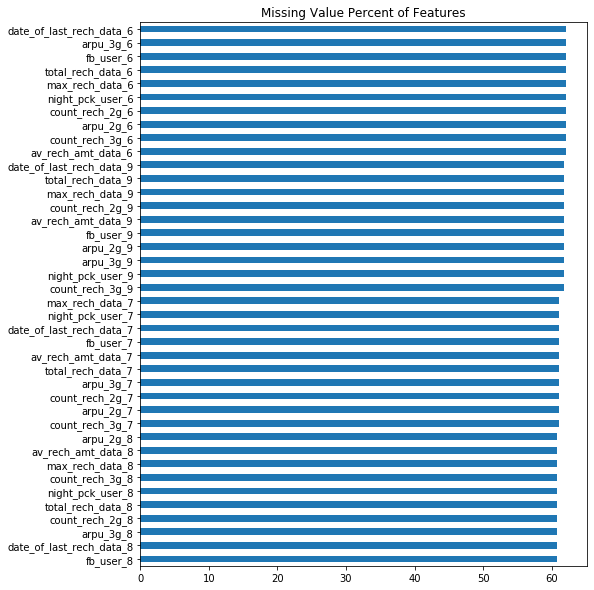

In [423]:
# Check amount of missing data in the columns
missing_data = round(100*telecom_hvc.isnull().sum()/len(telecom_hvc),2)
missing_data[missing_data > 30].sort_values().plot(kind='barh',figsize=(8,10))
plt.title('Missing Value Percent of Features')

In [424]:
# Dropping all columns having more than 30 percent of Missing Data
to_drop = list(missing_data[missing_data > 30].index)
telecom_hvc.drop(to_drop,1,inplace=True)
telecom_hvc.shape

(30098, 185)

**Tag churners and remove attributes of the churn phase**

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names)

In [425]:
# Create a churn column based on 9th month usage
telecom_hvc['churn'] = telecom_hvc.apply(lambda x:1 if x.total_ic_mou_9+x.total_og_mou_9+x.vol_2g_mb_9+x.vol_3g_mb_9 ==0 else 0,axis=1)
telecom_hvc.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
13            6/30/2014            7/31/2014            8/31/2014   
16            6/30/2014            7/31/2014            8/31/2014   
17            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
7             9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8             9/30/2014   378.721   492.223   137.362  166.787       413.69   
13            9/30/2014   492.846   205.671   593.260  322.732       501.76   
16            9/30/2014   430.975   299.869   187.894  206.490        50.51   
17            9/30/2014   690.008    18.980    25.499  257.583      1185.91   

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
7         54.68        52.29          NaN        453.43        567.16   
8        351.03        35.08        33.46         94.66         80.63   
13       108.39       534.24       244.81        413.31        119.28   
16        74.01        70.61        31.34        296.29        229.74   
17         9.28         7.79       558.51         61.64          0.00   

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
7         325.91           NaN          16.23          33.49          31.64   
8         136.48        108.71           0.00           0.00           0.00   
13        482.46        214.06          23.53         144.24          72.11   
16        162.76        224.39           0.00           2.83           0.00   
17          5.54         87.89           0.00           4.76           4.81   

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
7             NaN          23.74          12.59          38.06            NaN   
8            0.00           0.00           0.00           0.00           0.00   
13         136.78           7.98          35.26           1.44          12.78   
16           0.00           0.00          17.74           0.00           0.00   
17           0.00           0.00           8.46          13.34          17.98   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
7              51.39             31.38             40.28               NaN   
8             297.13            217.59             12.49             26.13   
13             49.63              6.19             36.01              6.14   
16             42.61             65.16             67.38             26.88   
17             38.99              0.00              0.00             36.41   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
7             308.63            447.38            162.28               NaN   
8              80.96             70.58             50.54             34.58   
13            151.13             47.28            294.46            108.24   
16            273.29            145.99            128.28            201.49   
17             58.54              0.00              0.00              9.38   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
7              62.13             55.14             53.23               NaN   
8               0.00              0.00              0.00              0.00   
13              4.54              0.00             23.51    

In [426]:
# 9th Month data is no longer needed so all columns with suffix _9 cn be dropped 
# Get the column list
to_drop_9th_cols = []
for i in telecom_hvc.columns.tolist():
    if i.endswith('_9'):
        to_drop_9th_cols.append(i)

to_drop_9th_cols

['last_date_of_month_9',
 'arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9']

In [427]:
# Dropping the columns
telecom_hvc.drop(to_drop_9th_cols,1,inplace=True)
telecom_hvc.shape

(30098, 142)

In [428]:
# Drop Mobile Number since it has got no predicatability
print(f'Number of unique value for Mobile number : {telecom_hvc.mobile_number.nunique()}')
telecom_hvc.drop(['mobile_number'],1,inplace=True)
telecom_hvc.shape

Number of unique value for Mobile number : 30098


(30098, 141)

In [429]:
# Given the business context date columns does not have much relevance. Hence dropping
to_drop_date_cols = []
for i in telecom_hvc.columns.tolist():
    if 'date' in i:
        to_drop_date_cols.append(i)
        
to_drop_date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8']

In [430]:
# Dropping the Date columns
telecom_hvc.drop(to_drop_date_cols,1,inplace=True)
telecom_hvc.shape

(30098, 135)

In [431]:
telecom_hvc.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6  \
7         109             0.0             0.0             0.0  1069.180   
8         109             0.0             0.0             0.0   378.721   
13        109             0.0             0.0             0.0   492.846   
16        109             0.0             0.0             0.0   430.975   
17        109             0.0             0.0             0.0   690.008   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
7   1349.850  3171.480        57.84        54.68        52.29        453.43   
8    492.223   137.362       413.69       351.03        35.08         94.66   
13   205.671   593.260       501.76       108.39       534.24        413.31   
16   299.869   187.894        50.51        74.01        70.61        296.29   
17    18.980    25.499      1185.91         9.28         7.79         61.64   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
7         567.16        325.91          16.23          33.49          31.64   
8          80.63        136.48           0.00           0.00           0.00   
13        119.28        482.46          23.53         144.24          72.11   
16        229.74        162.76           0.00           2.83           0.00   
17          0.00          5.54           0.00           4.76           4.81   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
7           23.74          12.59          38.06             51.39   
8            0.00           0.00           0.00            297.13   
13           7.98          35.26           1.44             49.63   
16           0.00          17.74           0.00             42.61   
17           0.00           8.46          13.34             38.99   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
7              31.38             40.28            308.63            447.38   
8             217.59             12.49             80.96             70.58   
13              6.19             36.01            151.13             47.28   
16             65.16             67.38            273.29            145.99   
17              0.00              0.00             58.54              0.00   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
7             162.28             62.13             55.14             53.23   
8              50.54              0.00              0.00              0.00   
13            294.46              4.54              0.00             23.51   
16            128.28              0.00              4.48             10.26   
17              0.00              0.00              0.00              0.00   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
7                0.0               0.0              0.00        422.16   
8                0.0               0.0              7.15        378.09   
13               0.0               0.0              0.49        205.31   
16               0.0               0.0              0.00        315.91   
17               0.0               0.0              0.00         97.54   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
7         533.91        255.79              4.30             23.29   
8         288.18         63.04            116.56            133.43   
13         53.48        353.99            446.41             85.98   
16        215.64        205.93              7.89              2.58   
17          0.00          0.00           1146.91              0.81   

    std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
7              12.01             49.89             31.76             49.14   
8              22.58             13.69             10.04             75.69   
13            498.23            255.36             52.94            156.94   
16              3.23             22.99             64.51             18.

In [432]:
# Drop Mobile Number since it has got no predicatability
print(f'Number of unique value for circle_id : {telecom_hvc.circle_id.nunique()}')
telecom_hvc.drop(['circle_id'],1,inplace=True)
telecom_hvc.shape

Number of unique value for circle_id : 1


(30098, 134)

#### Missing Value Imputation

Text(0.5, 1.0, 'Missing Value Percent of Features')

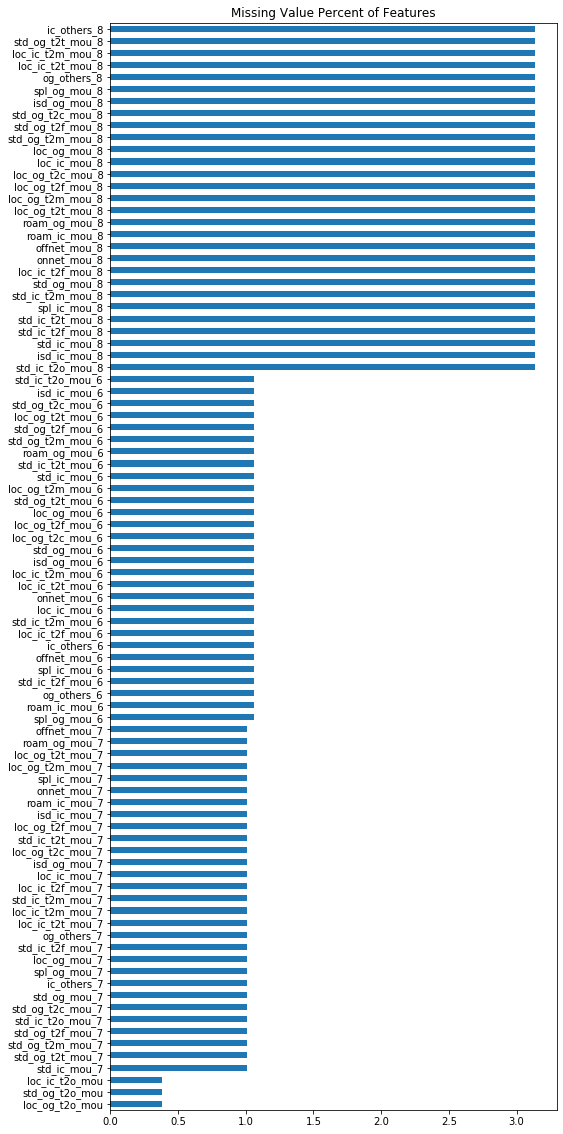

In [433]:
# Check amount of missing data in the columns
missing_data = round(100*telecom_hvc.isnull().sum()/len(telecom_hvc),2)
missing_data[missing_data != 0].sort_values().plot(kind='barh',figsize=(8,20))
plt.title('Missing Value Percent of Features')

In [434]:
# Check datatype of all columns
telecom_hvc.dtypes.value_counts()

float64    110
int64       24
dtype: int64

In [435]:
#check missing data in rows having 70% values missing
sum(telecom_hvc.isnull().sum(axis=1) > 100)

0

In [436]:
# Copy the telecom Dataframe to use for imputation
telecom_missing = telecom_hvc.copy()

In [437]:
# We see all columns are numerical columns
# We will use Iterative imputer to fill missing values
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
impute = IterativeImputer(n_nearest_features=50,min_value=0,random_state=100)
telecom_missing = impute.fit_transform(telecom_missing)


In [439]:
telecom_hvc = pd.DataFrame(data=telecom_missing,columns=telecom_hvc.columns)
telecom_hvc.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6    arpu_7  \
0             0.0             0.0             0.0  1069.180  1349.850   
1             0.0             0.0             0.0   378.721   492.223   
2             0.0             0.0             0.0   492.846   205.671   
3             0.0             0.0             0.0   430.975   299.869   
4             0.0             0.0             0.0   690.008    18.980   

     arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0  3171.480        57.84        54.68        52.29        453.43   
1   137.362       413.69       351.03        35.08         94.66   
2   593.260       501.76       108.39       534.24        413.31   
3   187.894        50.51        74.01        70.61        296.29   
4    25.499      1185.91         9.28         7.79         61.64   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0        567.16        325.91          16.23          33.49          31.64   
1         80.63        136.48           0.00           0.00           0.00   
2        119.28        482.46          23.53         144.24          72.11   
3        229.74        162.76           0.00           2.83           0.00   
4          0.00          5.54           0.00           4.76           4.81   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0          23.74          12.59          38.06             51.39   
1           0.00           0.00           0.00            297.13   
2           7.98          35.26           1.44             49.63   
3           0.00          17.74           0.00             42.61   
4           0.00           8.46          13.34             38.99   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             31.38             40.28            308.63            447.38   
1            217.59             12.49             80.96             70.58   
2              6.19             36.01            151.13             47.28   
3             65.16             67.38            273.29            145.99   
4              0.00              0.00             58.54              0.00   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0            162.28             62.13             55.14             53.23   
1             50.54              0.00              0.00              0.00   
2            294.46              4.54              0.00             23.51   
3            128.28              0.00              4.48             10.26   
4              0.00              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0               0.0              0.00        422.16   
1               0.0               0.0              7.15        378.09   
2               0.0               0.0              0.49        205.31   
3               0.0               0.0              0.00        315.91   
4               0.0               0.0              0.00         97.54   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0        533.91        255.79              4.30             23.29   
1        288.18         63.04            116.56            133.43   
2         53.48        353.99            446.41             85.98   
3        215.64        205.93              7.89              2.58   
4          0.00          0.00           1146.91              0.81   

   std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0             12.01             49.89             31.76             49.14   
1             22.58             13.69             10.04             75.69   
2            498.23            255.36             52.94            156.94   
3              3.23             22.99             64.51             18.29   
4              0.00              1.55              0.00              0.00   

   std_og_t2f_mou_6  std_og_t2f_mo

In [440]:
# check missing post imputation
missing_data = round(100*telecom_hvc.isnull().sum()/len(telecom_hvc),2)
missing_data[missing_data != 0]

Series([], dtype: float64)

In [441]:
telecom_hvc.shape

(30098, 134)

**Derived Features**

In [442]:
# The features for months 6 and 7 can be averaged to reduce the noise and reduce number of features.
# Reduced Noise will help in better predicatability
features_6 =[]
features_7=[]
exclude_list = ['avg_total_recharge_6_7']
for col in telecom_hvc.columns.tolist():
    if col.endswith('_6') and col not in exclude_list:
        features_6.append(col)
    elif col.endswith('_7') and col not in exclude_list:
        features_7.append(col)

In [443]:
print(len(features_6))
print(len(features_7))

41
41


In [444]:
# Check alignment of columns
features_6 = sorted(features_6)
features_7 = sorted(features_7)
list(zip(features_6,features_7))

[('arpu_6', 'arpu_7'),
 ('ic_others_6', 'ic_others_7'),
 ('isd_ic_mou_6', 'isd_ic_mou_7'),
 ('isd_og_mou_6', 'isd_og_mou_7'),
 ('last_day_rch_amt_6', 'last_day_rch_amt_7'),
 ('loc_ic_mou_6', 'loc_ic_mou_7'),
 ('loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7'),
 ('loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7'),
 ('loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7'),
 ('loc_og_mou_6', 'loc_og_mou_7'),
 ('loc_og_t2c_mou_6', 'loc_og_t2c_mou_7'),
 ('loc_og_t2f_mou_6', 'loc_og_t2f_mou_7'),
 ('loc_og_t2m_mou_6', 'loc_og_t2m_mou_7'),
 ('loc_og_t2t_mou_6', 'loc_og_t2t_mou_7'),
 ('max_rech_amt_6', 'max_rech_amt_7'),
 ('monthly_2g_6', 'monthly_2g_7'),
 ('monthly_3g_6', 'monthly_3g_7'),
 ('offnet_mou_6', 'offnet_mou_7'),
 ('og_others_6', 'og_others_7'),
 ('onnet_mou_6', 'onnet_mou_7'),
 ('roam_ic_mou_6', 'roam_ic_mou_7'),
 ('roam_og_mou_6', 'roam_og_mou_7'),
 ('sachet_2g_6', 'sachet_2g_7'),
 ('sachet_3g_6', 'sachet_3g_7'),
 ('spl_ic_mou_6', 'spl_ic_mou_7'),
 ('spl_og_mou_6', 'spl_og_mou_7'),
 ('std_ic_mou_6', 'std_ic_mou_7'),
 

In [445]:
# Create average features for all month 6 and 7 metrics - 41 new columns
for i,col in enumerate(features_6):
        new_col = 'avg_'+ col[:-2] + '_6_7'
        telecom_hvc[new_col] = telecom_hvc[features_6[i]] + telecom_hvc[features_7[i]]
        
telecom_hvc.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6    arpu_7  \
0             0.0             0.0             0.0  1069.180  1349.850   
1             0.0             0.0             0.0   378.721   492.223   
2             0.0             0.0             0.0   492.846   205.671   
3             0.0             0.0             0.0   430.975   299.869   
4             0.0             0.0             0.0   690.008    18.980   

     arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0  3171.480        57.84        54.68        52.29        453.43   
1   137.362       413.69       351.03        35.08         94.66   
2   593.260       501.76       108.39       534.24        413.31   
3   187.894        50.51        74.01        70.61        296.29   
4    25.499      1185.91         9.28         7.79         61.64   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0        567.16        325.91          16.23          33.49          31.64   
1         80.63        136.48           0.00           0.00           0.00   
2        119.28        482.46          23.53         144.24          72.11   
3        229.74        162.76           0.00           2.83           0.00   
4          0.00          5.54           0.00           4.76           4.81   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0          23.74          12.59          38.06             51.39   
1           0.00           0.00           0.00            297.13   
2           7.98          35.26           1.44             49.63   
3           0.00          17.74           0.00             42.61   
4           0.00           8.46          13.34             38.99   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0             31.38             40.28            308.63            447.38   
1            217.59             12.49             80.96             70.58   
2              6.19             36.01            151.13             47.28   
3             65.16             67.38            273.29            145.99   
4              0.00              0.00             58.54              0.00   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0            162.28             62.13             55.14             53.23   
1             50.54              0.00              0.00              0.00   
2            294.46              4.54              0.00             23.51   
3            128.28              0.00              4.48             10.26   
4              0.00              0.00              0.00              0.00   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0               0.0               0.0              0.00        422.16   
1               0.0               0.0              7.15        378.09   
2               0.0               0.0              0.49        205.31   
3               0.0               0.0              0.00        315.91   
4               0.0               0.0              0.00         97.54   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0        533.91        255.79              4.30             23.29   
1        288.18         63.04            116.56            133.43   
2         53.48        353.99            446.41             85.98   
3        215.64        205.93              7.89              2.58   
4          0.00          0.00           1146.91              0.81   

   std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
0             12.01             49.89             31.76             49.14   
1             22.58             13.69             10.04             75.69   
2            498.23            255.36             52.94            156.94   
3              3.23             22.99             64.51             18.29   
4              0.00              1.55              0.00              0.00   

   std_og_t2f_mou_6  std_og_t2f_mo

In [446]:
telecom_hvc.shape

(30098, 175)

In [447]:
# We can drop the 6th and 7th month indivisual metric as they are redundant and highly correlated to the avg column
telecom_hvc.drop(features_6,1,inplace=True)
telecom_hvc.drop(features_7,1,inplace=True)
telecom_hvc.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_8  onnet_mou_8  \
0             0.0             0.0             0.0  3171.480        52.29   
1             0.0             0.0             0.0   137.362        35.08   
2             0.0             0.0             0.0   593.260       534.24   
3             0.0             0.0             0.0   187.894        70.61   
4             0.0             0.0             0.0    25.499         7.79   

   offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  \
0        325.91          31.64          38.06             40.28   
1        136.48           0.00           0.00             12.49   
2        482.46          72.11           1.44             36.01   
3        162.76           0.00           0.00             67.38   
4          5.54           4.81          13.34              0.00   

   loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
0            162.28             53.23              0.00        255.79   
1             50.54              0.00              7.15         63.04   
2            294.46             23.51              0.49        353.99   
3            128.28             10.26              0.00        205.93   
4              0.00              0.00              0.00          0.00   

   std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  std_og_t2c_mou_8  \
0             12.01             49.14             16.68               0.0   
1             22.58             75.69              0.00               0.0   
2            498.23            156.94              0.00               0.0   
3              3.23             18.29              0.00               0.0   
4              0.00              0.00              0.00               0.0   

   std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0         77.84         10.01          6.50          0.0          350.16   
1         98.28          0.00         10.23          0.0          171.56   
2        655.18          1.29          4.78          0.0         1015.26   
3         21.53          0.00          5.91          0.0          233.38   
4          0.00          0.00          0.00          0.0            0.00   

   loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0             27.31            121.19             39.53        188.04   
1              0.31             15.48              0.00         15.79   
2             52.58            195.18              7.49        255.26   
3             28.89            150.16             32.71        211.78   
4              0.00              0.00              0.00          0.00   

   std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_t2o_mou_8  \
0             30.39            141.33             22.21               0.0   
1              0.10              0.65              0.00               0.0   
2            154.58            317.91              1.91               0.0   
3              6.33             73.93              2.18               0.0   
4              0.00              0.00              0.00               0.0   

   std_ic_mou_8  total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  \
0        193.94          428.74           0.0         31.59        15.14   
1          0.75           16.54           0.0          0.00         0.00   
2        474.41         1144.53           0.0        393.39        21.44   
3         82.44          294.46           0.0          0.23         0.00   
4          0.00            0.00           0.0          0.00         0.00   

   total_rech_num_8  total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  \
0               7.0            3638.0          1580.0               779.0   
1              14.0             120.0            30.0                10.0   
2              11.0             717.0           130.0                 0.0   
3               2.0             160.0           130.0               130.0   
4               4.0              30.0   

In [448]:
telecom_hvc.shape

(30098, 93)

In [449]:
# Check columns with only unique value hence no predictive power
(telecom_hvc.nunique().sort_values() == 1).head(10)

loc_og_t2o_mou             True
std_ic_t2o_mou_8           True
avg_std_ic_t2o_mou_6_7     True
avg_std_og_t2c_mou_6_7     True
std_og_t2c_mou_8           True
std_og_t2o_mou             True
loc_ic_t2o_mou             True
churn                     False
monthly_2g_8              False
avg_monthly_2g_6_7        False
dtype: bool

In [450]:
# Drop those columns
to_drop_list = (telecom_hvc.nunique().sort_values() == 1).head(7).index.tolist()
to_drop_list

['loc_og_t2o_mou',
 'std_ic_t2o_mou_8',
 'avg_std_ic_t2o_mou_6_7',
 'avg_std_og_t2c_mou_6_7',
 'std_og_t2c_mou_8',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou']

In [451]:
# Drop
telecom_hvc.drop(to_drop_list,1,inplace=True)
telecom_hvc.shape

(30098, 86)

In [452]:
telecom_hvc.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0  3171.480        52.29        325.91          31.64          38.06   
1   137.362        35.08        136.48           0.00           0.00   
2   593.260       534.24        482.46          72.11           1.44   
3   187.894        70.61        162.76           0.00           0.00   
4    25.499         7.79          5.54           4.81          13.34   

   loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0             40.28            162.28             53.23              0.00   
1             12.49             50.54              0.00              7.15   
2             36.01            294.46             23.51              0.49   
3             67.38            128.28             10.26              0.00   
4              0.00              0.00              0.00              0.00   

   loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
0        255.79             12.01             49.14             16.68   
1         63.04             22.58             75.69              0.00   
2        353.99            498.23            156.94              0.00   
3        205.93              3.23             18.29              0.00   
4          0.00              0.00              0.00              0.00   

   std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0         77.84         10.01          6.50          0.0          350.16   
1         98.28          0.00         10.23          0.0          171.56   
2        655.18          1.29          4.78          0.0         1015.26   
3         21.53          0.00          5.91          0.0          233.38   
4          0.00          0.00          0.00          0.0            0.00   

   loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0             27.31            121.19             39.53        188.04   
1              0.31             15.48              0.00         15.79   
2             52.58            195.18              7.49        255.26   
3             28.89            150.16             32.71        211.78   
4              0.00              0.00              0.00          0.00   

   std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0             30.39            141.33             22.21        193.94   
1              0.10              0.65              0.00          0.75   
2            154.58            317.91              1.91        474.41   
3              6.33             73.93              2.18         82.44   
4              0.00              0.00              0.00          0.00   

   total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0          428.74           0.0         31.59        15.14               7.0   
1           16.54           0.0          0.00         0.00              14.0   
2         1144.53           0.0        393.39        21.44              11.0   
3          294.46           0.0          0.23         0.00               2.0   
4            0.00           0.0          0.00         0.00               4.0   

   total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  vol_2g_mb_8  \
0            3638.0          1580.0               779.0         0.00   
1             120.0            30.0                10.0         0.03   
2             717.0           130.0                 0.0         0.02   
3             160.0           130.0               130.0         0.00   
4              30.0            30.0                 0.0         0.00   

   vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8     aon  \
0         0.00           0.0          0.0           0.0          0.0   802.0   
1        11.94           0.0          3.0           0.0          0.0   315.0   
2         0.00           0.0          3.0           0.0          0.0  2607.0   
3         0.00           0.0          0.0           0.0          0.0   511.0   
4         0.00       

In [453]:
# The vbc columns do not follow the overall naming convention hence renaming
telecom_hvc.rename(columns={'jun_vbc_3g':'vbc_3g_6', 
                             'jul_vbc_3g':'vbc_3g_7',
                             'aug_vbc_3g':'vbc_3g_8',
                             'sep_vbc_3g':'vbc_3g_9'},inplace=True)
telecom_hvc.head()
                            

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0  3171.480        52.29        325.91          31.64          38.06   
1   137.362        35.08        136.48           0.00           0.00   
2   593.260       534.24        482.46          72.11           1.44   
3   187.894        70.61        162.76           0.00           0.00   
4    25.499         7.79          5.54           4.81          13.34   

   loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0             40.28            162.28             53.23              0.00   
1             12.49             50.54              0.00              7.15   
2             36.01            294.46             23.51              0.49   
3             67.38            128.28             10.26              0.00   
4              0.00              0.00              0.00              0.00   

   loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  std_og_t2f_mou_8  \
0        255.79             12.01             49.14             16.68   
1         63.04             22.58             75.69              0.00   
2        353.99            498.23            156.94              0.00   
3        205.93              3.23             18.29              0.00   
4          0.00              0.00              0.00              0.00   

   std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  total_og_mou_8  \
0         77.84         10.01          6.50          0.0          350.16   
1         98.28          0.00         10.23          0.0          171.56   
2        655.18          1.29          4.78          0.0         1015.26   
3         21.53          0.00          5.91          0.0          233.38   
4          0.00          0.00          0.00          0.0            0.00   

   loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  \
0             27.31            121.19             39.53        188.04   
1              0.31             15.48              0.00         15.79   
2             52.58            195.18              7.49        255.26   
3             28.89            150.16             32.71        211.78   
4              0.00              0.00              0.00          0.00   

   std_ic_t2t_mou_8  std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0             30.39            141.33             22.21        193.94   
1              0.10              0.65              0.00          0.75   
2            154.58            317.91              1.91        474.41   
3              6.33             73.93              2.18         82.44   
4              0.00              0.00              0.00          0.00   

   total_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0          428.74           0.0         31.59        15.14               7.0   
1           16.54           0.0          0.00         0.00              14.0   
2         1144.53           0.0        393.39        21.44              11.0   
3          294.46           0.0          0.23         0.00               2.0   
4            0.00           0.0          0.00         0.00               4.0   

   total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  vol_2g_mb_8  \
0            3638.0          1580.0               779.0         0.00   
1             120.0            30.0                10.0         0.03   
2             717.0           130.0                 0.0         0.02   
3             160.0           130.0               130.0         0.00   
4              30.0            30.0                 0.0         0.00   

   vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8     aon  \
0         0.00           0.0          0.0           0.0          0.0   802.0   
1        11.94           0.0          3.0           0.0          0.0   315.0   
2         0.00           0.0          3.0           0.0          0.0  2607.0   
3         0.00           0.0          0.0           0.0          0.0   511.0   
4         0.00       

In [454]:
# Treating vbc variables as per overall scheme
telecom_hvc['avg_vbc_3g_6_7'] = round((telecom_hvc.vbc_3g_6 + telecom_hvc.vbc_3g_7)/2,2)

# Drop 6,7,9th month vbc
telecom_hvc.drop(['vbc_3g_9','vbc_3g_6','vbc_3g_7'],1,inplace=True)


In [455]:
telecom_hvc.shape

(30098, 84)

#### Check correlation between features

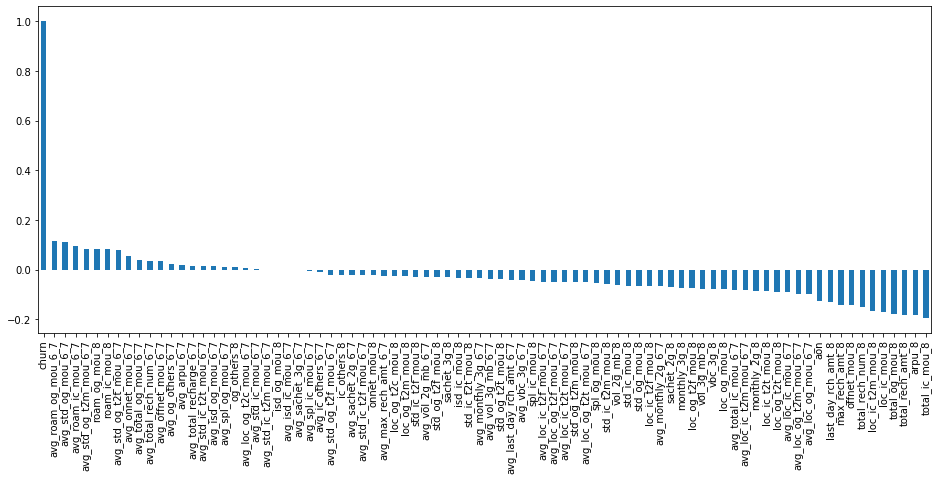

In [456]:
# Check correlation of churn with other features
telecom_hvc.corr()['churn'].sort_values(ascending=False).plot(kind='bar',figsize=(16,6))

`Top positive correlated features with Churn`
- avg_roam_og_mou_6_7       
- avg_std_og_mou_6_7  
- avg_roam_ic_mou_6_7       
- avg_std_og_t2t_mou_6_7    
- avg_std_og_t2m_mou_6_7    

`Top Negative correlated features with Churn`
- loc_ic_mou_8       
- total_ic_mou_8     
- arpu_8             
- total_rech_amt_8 
- total_og_mou_8     

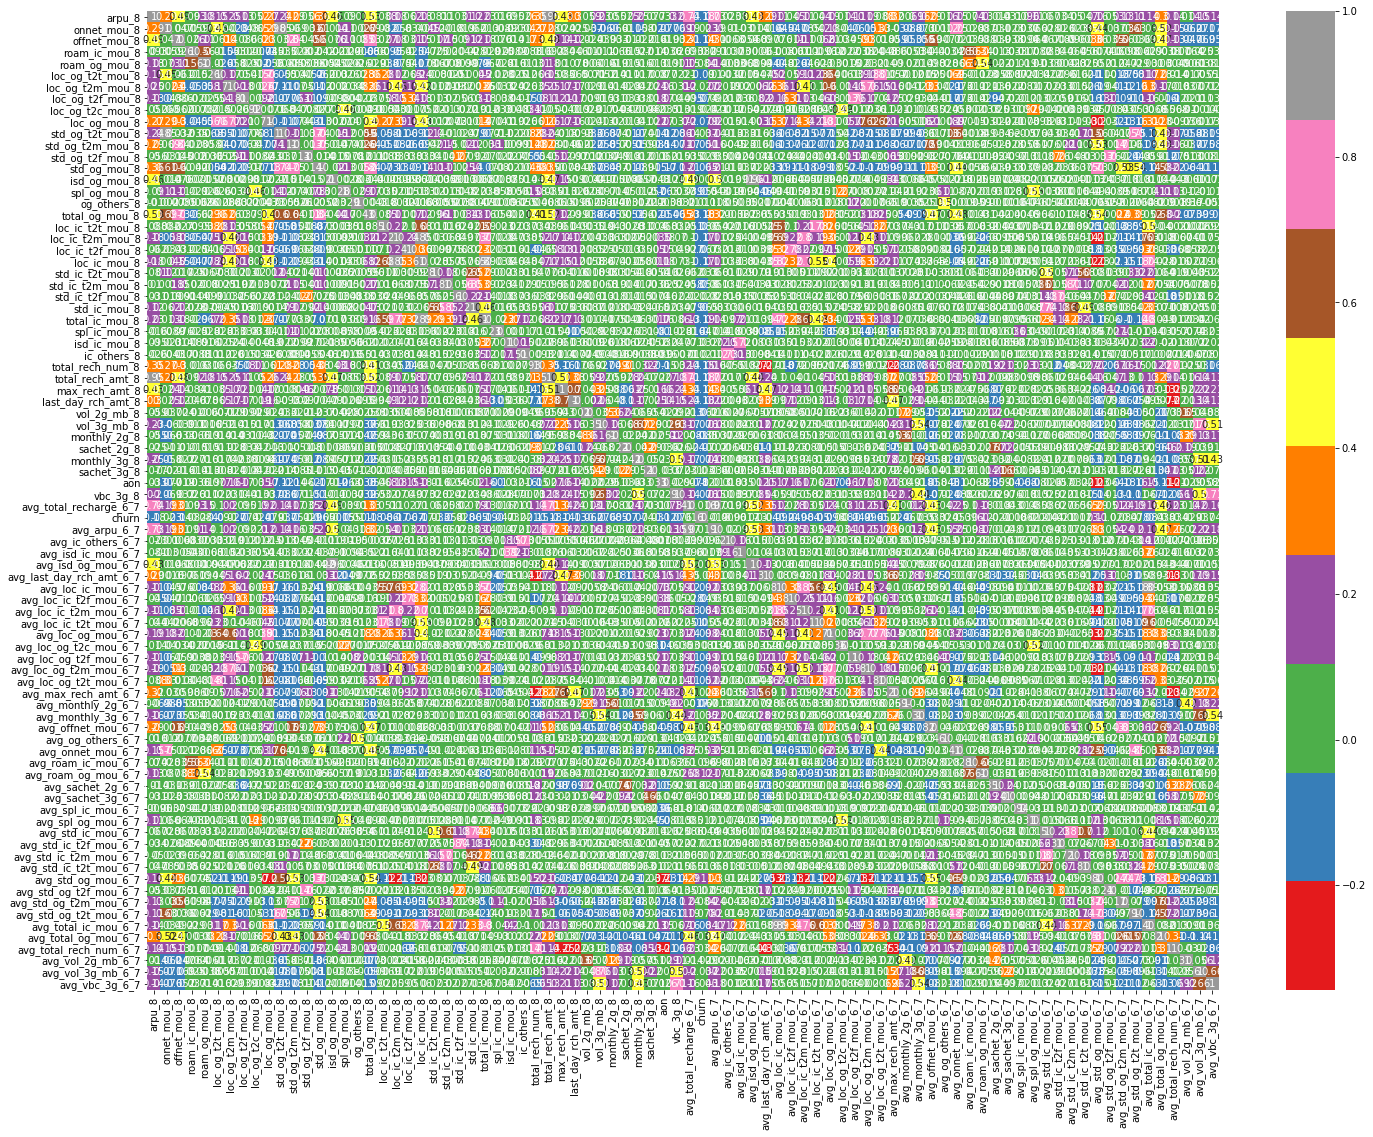

In [457]:
# Check correlation between all features
plt.figure(figsize=(24,18))
sns.heatmap(telecom_hvc.corr(),annot=True,cmap='Set1')

In [460]:
# We can see there are few features having very high positive correlation > 0.85.
# Lets find those features and we can choose to drop them.

# Create correlation matrix
corr_matrix = telecom_hvc.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [461]:
# Create a dataframe to store features correlation above 0.85
# to select the feature to drop from high correlated feature we would also consider feature correlation with Churn

# Create a list by iterating over all correlations
rel = [(index,round(telecom_hvc['churn'].corr(telecom_hvc[index]),2),column,round(telecom_hvc['churn'].corr(telecom_hvc[column]),2),round(upper[index][column],2)) for index in upper.index for column in upper.columns if upper[index][column] > 0.85]

# Create a Dataframe out of the list
high_corr = pd.DataFrame(data=rel,columns=['feature1','feature1_corr_churn','feature2','feature2_corr_churn','feature1_corr_feature2'])

high_corr

feature1  feature1_corr_churn                feature2  \
0      std_og_t2t_mou_8                -0.04             onnet_mou_8   
1          loc_ic_mou_8                -0.17        loc_ic_t2m_mou_8   
2        total_ic_mou_8                -0.19            loc_ic_mou_8   
3      total_rech_amt_8                -0.18                  arpu_8   
4          avg_arpu_6_7                 0.02  avg_total_recharge_6_7   
5    avg_isd_og_mou_6_7                 0.01            isd_og_mou_8   
6  avg_total_ic_mou_6_7                -0.08      avg_loc_ic_mou_6_7   

   feature2_corr_churn  feature1_corr_feature2  
0                -0.02                    0.85  
1                -0.17                    0.85  
2                -0.17                    0.89  
3                -0.18                    0.95  
4                 0.02                    0.97  
5                -0.00                    0.96  
6                -0.09                    0.89

In [ ]:
# Selecting features to drop taking into cosideration there corelation with Churn
top_corr_drop = ['std_og_t2t_mou_8','std_og_t2m_mou_8','loc_ic_t2m_mou_8','loc_ic_mou_8','arpu_8','avg_arpu_6_7','avg_isd_og_mou_6_7','avg_total_ic_mou_6_7']

# Dropping the columns
telecom_hvc.drop(top_corr_drop,1,inplace=True)


In [464]:
telecom_hvc.shape

(30098, 76)

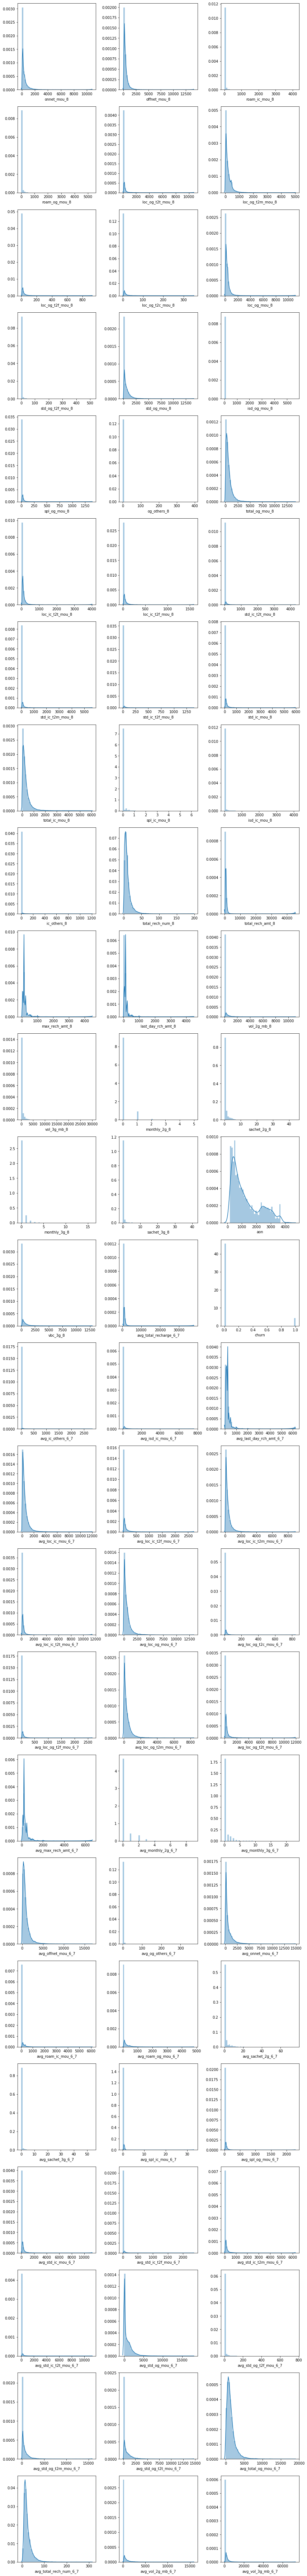

In [465]:
# Check distribution of all columns
# Lets do a scatterplot of all top correlated features with SalesPrice
%matplotlib inline
fig,ax = plt.subplots(25,3,figsize=(12,100))
ax = ax.flatten()
for axes,col in zip(ax,telecom_hvc.columns):
    sns.distplot(telecom_hvc[col],ax=axes)
plt.tight_layout()  


In [466]:
# Lets check the top positive correlated features 
pos_features = telecom_hvc.corr()['churn'].sort_values(ascending=False).head(11).index[1:].tolist()
pos_features

['avg_roam_og_mou_6_7',
 'avg_std_og_mou_6_7',
 'avg_roam_ic_mou_6_7',
 'avg_std_og_t2m_mou_6_7',
 'roam_og_mou_8',
 'roam_ic_mou_8',
 'avg_std_og_t2t_mou_6_7',
 'avg_onnet_mou_6_7',
 'avg_total_og_mou_6_7',
 'avg_total_rech_num_6_7']

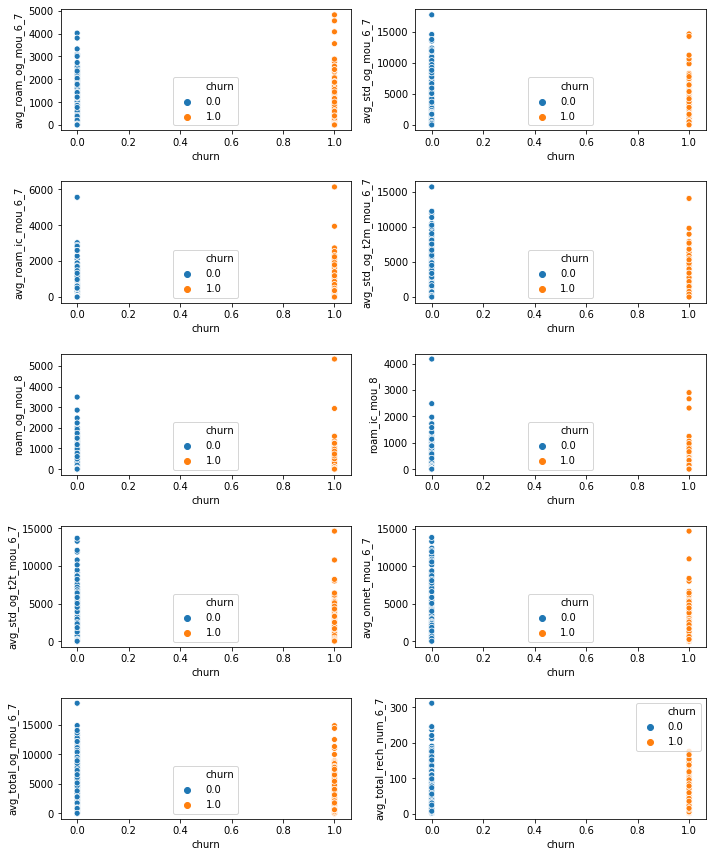

In [467]:
# Check distribution of all columns
# Lets do a scatterplot of all top correlated features with SalesPrice
%matplotlib inline
fig,ax = plt.subplots(5,2,figsize=(10,12))
ax = ax.flatten()
for axes,col in zip(ax,pos_features):
    sns.scatterplot(x='churn',y=col,hue='churn',data=telecom_hvc,ax=axes)
plt.tight_layout()  

`We can see for the churn customers the average of the feature is higher than non - churn customers`

In [469]:
# Lets check the top negative correlated features 
neg_features = telecom_hvc.corr()['churn'].sort_values().head(10).index.tolist()
neg_features

['total_ic_mou_8',
 'total_rech_amt_8',
 'total_og_mou_8',
 'total_rech_num_8',
 'offnet_mou_8',
 'max_rech_amt_8',
 'last_day_rch_amt_8',
 'aon',
 'avg_loc_og_mou_6_7',
 'avg_loc_og_t2m_mou_6_7']

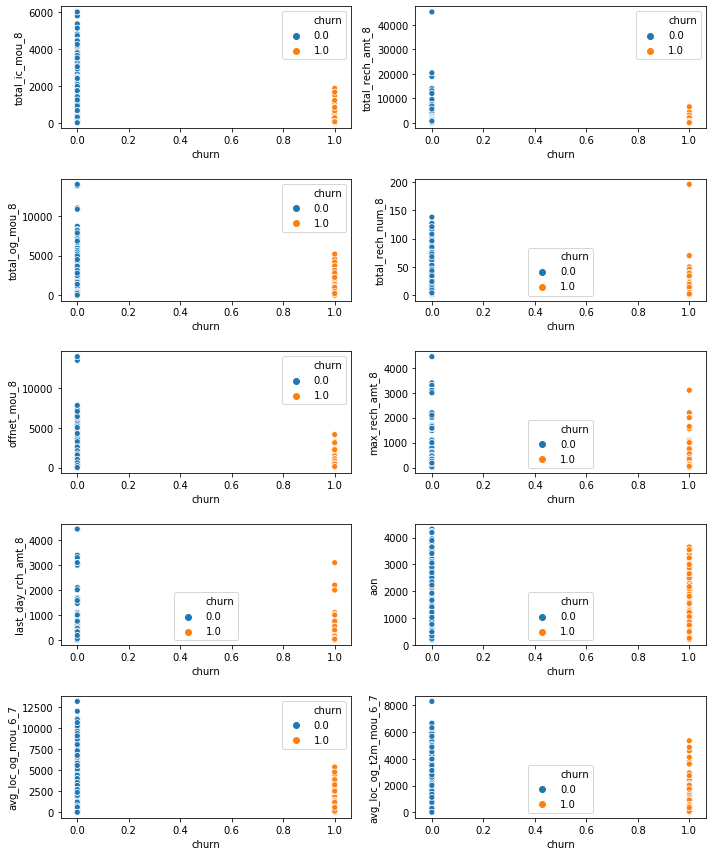

In [471]:
# Check distribution of all columns
# Lets do a scatterplot of all top correlated features with SalesPrice
%matplotlib inline
fig,ax = plt.subplots(5,2,figsize=(10,12))
ax = ax.flatten()
for axes,col in zip(ax,neg_features):
    sns.scatterplot(x='churn',y=col,hue='churn',data=telecom_hvc,ax=axes)
plt.tight_layout()  

`We can see for the churn customers the average of the feature is lower than non-churn customers` 

## Outlier detection

In [475]:
telecom_hvc.describe(percentiles=[0.03,0.05,0.08,0.1,0.5,0.75,0.9,0.95,0.98,0.99,0.995,0.998,0.999])

onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
count  30098.000000  30098.000000   30098.000000   30098.000000   
mean     280.537818    375.488906      13.974768      22.027226   
std      465.459103    476.440066      74.941197     106.310703   
min        0.000000      0.000000       0.000000       0.000000   
3%         0.000000      0.000000       0.000000       0.000000   
5%         1.000000      1.800000       0.000000       0.000000   
8%         4.310000     13.530000       0.000000       0.000000   
10%        6.860000     23.422000       0.000000       0.000000   
50%      112.860000    240.835000       0.000000       0.000000   
75%      336.302500    482.120000       0.000000       0.000000   
90%      731.349000    852.125000      22.416000      42.083000   
95%     1116.017500   1187.445500      70.741216     116.554000   
98%     1700.147200   1737.887800     169.350200     267.119000   
99%     2189.181700   2207.135400     290.391400     432.965400   
99.5%   2759.161950   2833.845800     413.857250     633.614750   
99.8%   3557.654340   3691.096020     690.692684    1094.667000   
99.9%   4245.490050   4471.271750     927.459560    1364.639550   
max    10752.560000  14007.340000    4169.810000    5337.040000   

       loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
count      30098.000000      30098.000000      30098.000000      30098.000000   
mean          87.234017        181.334337          6.513588          1.739930   
std          234.360216        238.063959         20.204099          7.410097   
min            0.000000          0.000000          0.000000          0.000000   
3%             0.000000          0.000000          0.000000          0.000000   
5%             0.000000          0.000000          0.000000          0.000000   
8%             0.000000          1.860000          0.000000          0.000000   
10%            0.330000          3.990000          0.000000          0.000000   
50%           28.760000        101.915000          0.210000          0.000000   
75%           84.625000        250.010000          4.730000          0.230000   
90%          196.896000        441.426088         16.990000          4.493000   
95%          323.725000        589.585500         31.343000          9.381500   
98%          595.913600        857.544200         60.111800         18.736000   
99%          955.301400       1094.987100         86.680000         28.980300   
99.5%       1498.729000       1380.869650        119.016200         40.310600   
99.8%       2160.923500       1798.779600        169.595100         59.744480   
99.9%       2845.446230       2099.362169        239.131790         81.441500   
max        10752.560000       4961.330000        928.490000        351.830000   

       loc_og_mou_8  std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  \
count  30098.000000      30098.000000  30098.000000  30098.000000   
mean     275.090694          1.832880    359.647054      2.103952   
std      364.999518         11.717763    613.197694     45.080333   
min        0.000000          0.000000      0.000000      0.000000   
3%         0.000000          0.000000      0.000000      0.000000   
5%         0.000000          0.000000      0.000000      0.000000   
8%         4.037600          0.000000      0.000000      0.000000   
10%        8.068000          0.000000      0.000000      0.000000   
50%      166.260000          0.000000     93.000000      0.000000   
75%      383.587500          0.000000    481.880000      0.000000   
90%      636.446000          2.030000   1056.168000      0.000000   
95%      884.390000          7.351500   1517.476500      0.580000   
98%     1306.631800         21.361200   2164.460600      8.181800   
99%     1689.193700         39.547200   2787.298000     32.444200   
99.5%   2065.829250         66.255700   3470.682100     98.696050   
99.8%   2681.417780        114.434940   4458.563000    215.617400   
99.9%   3373.911960  

In [483]:
# We can see almost all columns have outliers on the higher side except aon,churn. We will cap them using numpy clip
for col in telecom_hvc.columns.difference(['aon','churn']):
    lower = telecom_hvc[col].min()
    upper = telecom_hvc[col].quantile(0.999)
    telecom_hvc[col] = np.clip(telecom_hvc[col],lower,upper)


In [484]:
# So we can see all outliers are capped
telecom_hvc.describe(percentiles=[0.03,0.05,0.08,0.1,0.5,0.75,0.9,0.95,0.98,0.99,0.995,0.998,0.999])

onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
count  30098.000000  30098.000000   30098.000000   30098.000000   
mean     278.935037    373.944371      13.399604      21.452402   
std      445.853748    454.855251      60.907480      93.661024   
min        0.000000      0.000000       0.000000       0.000000   
3%         0.000000      0.000000       0.000000       0.000000   
5%         1.000000      1.800000       0.000000       0.000000   
8%         4.310000     13.530000       0.000000       0.000000   
10%        6.860000     23.422000       0.000000       0.000000   
50%      112.860000    240.835000       0.000000       0.000000   
75%      336.302500    482.120000       0.000000       0.000000   
90%      731.349000    852.125000      22.416000      42.083000   
95%     1116.017500   1187.445500      70.741216     116.554000   
98%     1700.147200   1737.887800     169.350200     267.119000   
99%     2189.181700   2207.135400     290.391400     432.965400   
99.5%   2759.161950   2833.845800     413.857250     633.614750   
99.8%   3557.654340   3691.096020     690.692684    1094.667000   
99.9%   4237.751385   4470.198760     926.538103    1364.214734   
max     4245.490050   4471.271750     927.459560    1364.639550   

       loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
count      30098.000000      30098.000000      30098.000000      30098.000000   
mean          85.815900        180.722233          6.400091          1.670990   
std          203.869130        231.298606         17.870948          5.899606   
min            0.000000          0.000000          0.000000          0.000000   
3%             0.000000          0.000000          0.000000          0.000000   
5%             0.000000          0.000000          0.000000          0.000000   
8%             0.000000          1.860000          0.000000          0.000000   
10%            0.330000          3.990000          0.000000          0.000000   
50%           28.760000        101.915000          0.210000          0.000000   
75%           84.625000        250.010000          4.730000          0.230000   
90%          196.896000        441.426088         16.990000          4.493000   
95%          323.725000        589.585500         31.343000          9.381500   
98%          595.913600        857.544200         60.111800         18.736000   
99%          955.301400       1094.987100         86.680000         28.980300   
99.5%       1498.729000       1380.869650        119.016200         40.310600   
99.8%       2160.923500       1798.779600        169.595100         59.744480   
99.9%       2838.227856       2099.255768        238.699966         81.397705   
max         2845.446230       2099.362169        239.131790         81.441500   

       loc_og_mou_8  std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  \
count  30098.000000      30098.000000  30098.000000  30098.000000   
mean     273.729207          1.750455    358.046552      1.630140   
std      345.708495          9.821570    594.643117     17.442911   
min        0.000000          0.000000      0.000000      0.000000   
3%         0.000000          0.000000      0.000000      0.000000   
5%         0.000000          0.000000      0.000000      0.000000   
8%         4.037600          0.000000      0.000000      0.000000   
10%        8.068000          0.000000      0.000000      0.000000   
50%      166.260000          0.000000     93.000000      0.000000   
75%      383.587500          0.000000    481.880000      0.000000   
90%      636.446000          2.030000   1056.168000      0.000000   
95%      884.390000          7.351500   1517.476500      0.580000   
98%     1306.631800         21.361200   2164.460600      8.181800   
99%     1689.193700         39.547200   2787.298000     32.444200   
99.5%   2065.829250         66.255700   3470.682100     98.696050   
99.8%   2681.417780        114.434940   4458.563000    215.617400   
99.9%   3372.920430  

### Model Building  

In [620]:
# Create a copy of the data 
df = telecom_hvc.copy()
df.head()

onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2t_mou_8  \
0        52.29        325.91          31.64          38.06             40.28   
1        35.08        136.48           0.00           0.00             12.49   
2       534.24        482.46          72.11           1.44             36.01   
3        70.61        162.76           0.00           0.00             67.38   
4         7.79          5.54           4.81          13.34              0.00   

   loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
0            162.28             53.23              0.00        255.79   
1             50.54              0.00              7.15         63.04   
2            294.46             23.51              0.49        353.99   
3            128.28             10.26              0.00        205.93   
4              0.00              0.00              0.00          0.00   

   std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  \
0             16.68         77.84         10.01          6.50          0.0   
1              0.00         98.28          0.00         10.23          0.0   
2              0.00        655.18          1.29          4.78          0.0   
3              0.00         21.53          0.00          5.91          0.0   
4              0.00          0.00          0.00          0.00          0.0   

   total_og_mou_8  loc_ic_t2t_mou_8  loc_ic_t2f_mou_8  std_ic_t2t_mou_8  \
0          350.16             27.31             39.53             30.39   
1          171.56              0.31              0.00              0.10   
2         1015.26             52.58              7.49            154.58   
3          233.38             28.89             32.71              6.33   
4            0.00              0.00              0.00              0.00   

   std_ic_t2m_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  total_ic_mou_8  \
0            141.33             22.21        193.94          428.74   
1              0.65              0.00          0.75           16.54   
2            317.91              1.91        474.41         1144.53   
3             73.93              2.18         82.44          294.46   
4              0.00              0.00          0.00            0.00   

   spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0           0.0         31.59        15.14               7.0   
1           0.0          0.00         0.00              14.0   
2           0.0        393.39        21.44              11.0   
3           0.0          0.23         0.00               2.0   
4           0.0          0.00         0.00               4.0   

   total_rech_amt_8  max_rech_amt_8  last_day_rch_amt_8  vol_2g_mb_8  \
0            3638.0          1580.0               779.0         0.00   
1             120.0            30.0                10.0         0.03   
2             717.0           130.0                 0.0         0.02   
3             160.0           130.0               130.0         0.00   
4              30.0            30.0                 0.0         0.00   

   vol_3g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  sachet_3g_8     aon  \
0         0.00           0.0          0.0           0.0          0.0   802.0   
1        11.94           0.0          3.0           0.0          0.0   315.0   
2         0.00           0.0          3.0           0.0          0.0  2607.0   
3         0.00           0.0          0.0           0.0          0.0   511.0   
4         0.00           0.0          0.0           0.0          0.0   667.0   

   vbc_3g_8  avg_total_recharge_6_7  churn  avg_ic_others_6_7  \
0     57.74                  1185.0    1.0              30.93   
1     21.03                   519.0    0.0               0.00   
2      0.00                   380.0    0.0              99.72   
3      0.00                   459.0    0.0               0.00   
4      0.00                   408.0    0.0               0.00   

   avg_isd_ic_mou_6_7  avg_last_day_rch_amt_6_

In [621]:
# Create X and y variables
X = df.drop('churn',1)
y = df.churn

print(X.shape)
print(y.shape)

(30098, 75)
(30098,)


In [622]:
# Check distrubution in dataset
round(100*(y.value_counts()/len(y)),2)

0.0    91.34
1.0     8.66
Name: churn, dtype: float64

**We have a heavily imbalanced dataset. We will handle the imbalance prior to modelling**

In [623]:
# Split train and test dataset 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21068, 75)
(9030, 75)
(21068,)
(9030,)


In [624]:
# Check distrubution in train dataset
round(100*(y_train.value_counts()/len(y_train)),2)

0.0    91.4
1.0     8.6
Name: churn, dtype: float64

In [625]:
# Check distrubution in test dataset
round(100*(y_test.value_counts()/len(y_test)),2)

0.0    91.22
1.0     8.78
Name: churn, dtype: float64

In [628]:
# We will handle the imbalance by oversampling the churn data points. We will use SMOTE algorithm for it 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100)
X_train_bal,y_train_bal = sm.fit_sample(X_train,y_train)

In [631]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(38512, 75)
(38512,)


In [632]:
# Check distrubution in train dataset post over sampling
round(100*(y_train_bal.value_counts()/len(y_train_bal)),2)

1.0    50.0
0.0    50.0
Name: churn, dtype: float64

### Model to interpret features

In [657]:
# Lets fit a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# Create a Baseline Random Forest model 
rfc = RandomForestClassifier(max_depth=8,random_state=100)
rfc.fit(X_train_bal,y_train_bal)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [658]:
# Predict on the fitted model 
y_test_pred_rf = rfc.predict(X_test)

In [659]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred_rf))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      8237
         1.0       0.47      0.76      0.58       793

    accuracy                           0.90      9030
   macro avg       0.72      0.84      0.76      9030
weighted avg       0.93      0.90      0.91      9030



In [660]:
# Confusion Matrix
print(confusion_matrix(y_test,y_test_pred_rf))

[[7560  677]
 [ 189  604]]


In [661]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_rf).ravel()
print(f"Sensitivity is :{round(tp / (tp+fn),2)}")

Sensitivity is :0.76


In [662]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred_rf)

0.7616645649432535

**According to the problem statement we are more concerned about predicting the churn class accurately. The appropriate evaluation metric of the models in this case would be `Sensitivity/Recall score` of the churn class**

##### Tuning Max Depth

In [679]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'max_depth':range(6,20,2)}
rf = RandomForestClassifier(random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [684]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.837821      0.102211         0.080323        0.005336   
1       8.800064      0.407083         0.113354        0.021460   
2      10.176184      0.107336         0.103034        0.007564   
3      11.975486      0.223393         0.124368        0.010703   
4      13.017369      0.227427         0.145173        0.022047   
5      13.710342      0.184412         0.144882        0.006173   
6      14.144314      0.168423         0.143463        0.008623   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               6   {'max_depth': 6}           0.848351           0.897975   
1               8   {'max_depth': 8}           0.861335           0.922897   
2              10  {'max_depth': 10}           0.879252           0.945742   
3              12  {'max_depth': 12}           0.891716           0.958204   
4              14  {'max_depth': 14}           0.900026           0.967549   
5              16  {'max_depth': 16}           0.903402           0.968847   
6              18  {'max_depth': 18}           0.903142           0.971963   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.913529           0.914048           0.910413         0.896863   
1           0.937679           0.934303           0.931706         0.917584   
2           0.956894           0.954557           0.951182         0.937526   
3           0.973254           0.968060           0.966243         0.951495   
4           0.978707           0.973254           0.973773         0.958662   
5           0.979486           0.978707           0.980005         0.962089   
6           0.982602           0.982862           0.982083         0.964530   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.024945                7            0.916975            0.899507   
1        0.028548                6            0.945602            0.929888   
2        0.029377                5            0.969166            0.958777   
3        0.030278                4            0.988965            0.981888   
4        0.029530                3            0.997923            0.993963   
5        0.029630                2            0.999935            0.997533   
6        0.030966                1            1.000000            0.999805   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.899903            0.904966            0.901201   
1            0.927426            0.928205            0.931061   
2            0.956767            0.957936            0.958715   
3            0.980656            0.982019            0.980201   
4            0.994352            0.992600            0.993703   
5            0.998377            0.998637            0.998572   
6            0.999935            0.999935            0.999935   

   mean_train_score  std_train_score  
0          0.904510         0.006524  
1          0.932437         0.006704  
2          0.960272         0.004506  
3          0.982746         0.003187  
4          0.994508         0.001804  
5          0.998611         0.000771  
6          0.999922         0.000064

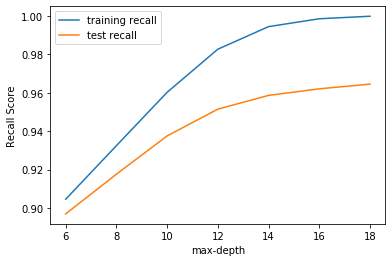

In [685]:
# PLot the score for train and test data
# plotting accuracies with n_estimators
col = 'max_depth'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [687]:
# We will consider 12 from the plot

#### Tuning n_estimators 

In [672]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'n_estimators':range(100,800,100)}
rf = RandomForestClassifier(max_depth=8,random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                    

In [676]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.477988      0.186408         0.091989        0.007461   
1      16.632864      0.095388         0.181198        0.007147   
2      25.848714      0.815846         0.269171        0.025271   
3      33.476279      0.186972         0.331767        0.010932   
4      41.918847      0.231222         0.429425        0.006193   

  param_n_estimators                 params  split0_test_score  \
0                100  {'n_estimators': 100}           0.861335   
1                200  {'n_estimators': 200}           0.860556   
2                300  {'n_estimators': 300}           0.860815   
3                400  {'n_estimators': 400}           0.859777   
4                500  {'n_estimators': 500}           0.860296   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.922897           0.937679           0.934303           0.931706   
1           0.926272           0.939237           0.934562           0.933004   
2           0.925493           0.938198           0.936120           0.931966   
3           0.926532           0.938977           0.936900           0.932225   
4           0.927830           0.938977           0.937938           0.933524   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.917584        0.028548                7            0.945602   
1         0.918726        0.029381                5            0.945472   
2         0.918519        0.029176                6            0.946121   
3         0.918882        0.029861                4            0.946251   
4         0.919713        0.029967                1            0.946641   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.929888            0.927426            0.928205   
1            0.931317            0.928724            0.929503   
2            0.931381            0.929374            0.930737   
3            0.932680            0.929309            0.931061   
4            0.932550            0.930217            0.931256   

   split4_train_score  mean_train_score  std_train_score  
0            0.931061          0.932437         0.006704  
1            0.931321          0.933268         0.006186  
2            0.931970          0.933917         0.006163  
3            0.932035          0.934267         0.006099  
4            0.933139          0.934761         0.006026

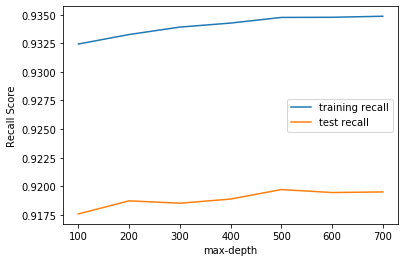

In [677]:
# PLot the score for train and test data
# plotting accuracies with n_estimators

col = 'n_estimators'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [688]:
# n_estimators = 200 gives decent results

#### Tuning max_features

In [689]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'max_features':[4,8,16,32]}
rf = RandomForestClassifier(max_depth=8,random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                    

In [690]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.629706      0.138673         0.110210        0.011075   
1       8.381858      0.058794         0.093131        0.008238   
2      16.130606      0.081346         0.094267        0.001046   
3      31.445807      0.269293         0.083001        0.005059   

  param_max_features                params  split0_test_score  \
0                  4   {'max_features': 4}           0.852506   
1                  8   {'max_features': 8}           0.861335   
2                 16  {'max_features': 16}           0.860296   
3                 32  {'max_features': 32}           0.864710   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.915109           0.922877           0.922098           0.914048   
1           0.922897           0.937679           0.934303           0.931706   
2           0.936137           0.945728           0.942353           0.944170   
3           0.939512           0.947027           0.947286           0.945728   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.905328        0.026650                4            0.933333   
1         0.917584        0.028548                3            0.945602   
2         0.925737        0.032882                2            0.951899   
3         0.928853        0.032195                1            0.956767   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.921254            0.915352            0.920026   
1            0.929888            0.927426            0.928205   
2            0.939756            0.936514            0.939370   
3            0.943067            0.940863            0.942616   

   split4_train_score  mean_train_score  std_train_score  
0            0.917105          0.921414         0.006314  
1            0.931061          0.932437         0.006704  
2            0.940669          0.941642         0.005313  
3            0.942486          0.945160         0.005851

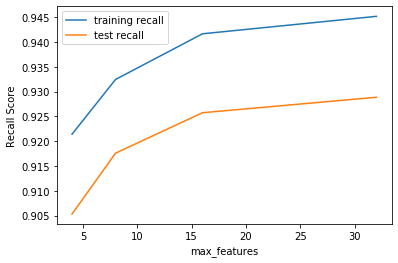

In [694]:
# PLot the score for train and test data
# plotting accuracies with n_estimators

col = 'max_features'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [695]:
# max_features = 15 looks good on test data

### Tuning min_samples_leaf

In [700]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'min_samples_leaf':range(30,240,30)}
rf = RandomForestClassifier(random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [702]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      11.232855      0.271250         0.124623        0.013495   
1       9.888101      0.083896         0.110624        0.002562   
2       9.171177      0.053489         0.108405        0.004327   
3       8.604145      0.039532         0.103618        0.008464   
4       8.132378      0.036091         0.097376        0.004457   
5       7.826160      0.056851         0.093350        0.000489   
6       7.512715      0.039952         0.093006        0.009058   

  param_min_samples_leaf                     params  split0_test_score  \
0                     30   {'min_samples_leaf': 30}           0.853804   
1                     60   {'min_samples_leaf': 60}           0.843677   
2                     90   {'min_samples_leaf': 90}           0.841600   
3                    120  {'min_samples_leaf': 120}           0.840042   
4                    150  {'min_samples_leaf': 150}           0.838224   
5                    180  {'min_samples_leaf': 180}           0.841859   
6                    210  {'min_samples_leaf': 210}           0.839263   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.929647           0.940016           0.938198           0.934562   
1           0.912513           0.926513           0.922877           0.918463   
2           0.904206           0.917684           0.914568           0.915087   
3           0.900571           0.914568           0.911711           0.908076   
4           0.894860           0.903661           0.909894           0.903402   
5           0.897975           0.903402           0.906777           0.904440   
6           0.890966           0.900026           0.905739           0.903142   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.919245        0.032912                1            0.944953   
1         0.904808        0.030921                2            0.926193   
2         0.898629        0.028884                3            0.916845   
3         0.894993        0.027873                4            0.912106   
4         0.890008        0.026330                6            0.906913   
5         0.890891        0.024685                5            0.906913   
6         0.887827        0.024789                7            0.900941   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.932031            0.931191            0.933853   
1            0.916256            0.910029            0.911717   
2            0.906323            0.901720            0.905810   
3            0.899377            0.898604            0.901136   
4            0.896261            0.890750            0.897176   
5            0.898273            0.891074            0.892438   
6            0.888406            0.888997            0.892308   

   split4_train_score  mean_train_score  std_train_score  
0            0.932165          0.934838         0.005130  
1            0.912691          0.915377         0.005779  
2            0.905485          0.907237         0.005073  
3            0.895878          0.901420         0.005605  
4            0.893152          0.896850         0.005525  
5            0.892762          0.896292         0.005853  
6            0.890880          0.892306         0.004534

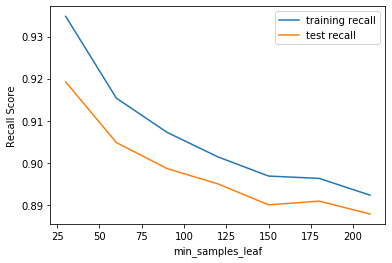

In [703]:
# PLot the score for train and test data
# plotting accuracies with n_estimators

col = 'min_samples_leaf'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [ ]:
# min_samples_leaf = 25 seems good on test data

### Tuning min_samples_split

In [708]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'min_samples_split':range(50,250,50)}
rf = RandomForestClassifier(random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [709]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      14.368828      0.123374         0.143856        0.009923   
1      13.792234      0.107827         0.133519        0.004560   
2      13.109926      0.068760         0.120164        0.006392   
3      12.771070      0.118586         0.117774        0.008339   

  param_min_samples_split                      params  split0_test_score  \
0                      50   {'min_samples_split': 50}           0.862373   
1                     100  {'min_samples_split': 100}           0.848091   
2                     150  {'min_samples_split': 150}           0.841340   
3                     200  {'min_samples_split': 200}           0.839522   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.941070           0.955596           0.950662           0.948325   
1           0.927051           0.943651           0.937419           0.937419   
2           0.921340           0.934303           0.930667           0.927292   
3           0.916667           0.929369           0.926253           0.920021   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.931605        0.034931                1            0.965660   
1         0.918726        0.035717                2            0.947874   
2         0.910988        0.035085                3            0.936060   
3         0.906366        0.033720                4            0.929568   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.954882            0.955339            0.955469   
1            0.935212            0.933918            0.934891   
2            0.923591            0.919701            0.923077   
3            0.918593            0.911977            0.916391   

   split4_train_score  mean_train_score  std_train_score  
0            0.955144          0.957299         0.004185  
1            0.934567          0.937292         0.005308  
2            0.924116          0.925309         0.005593  
3            0.914638          0.918233         0.006068

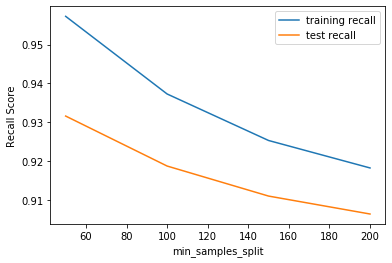

In [710]:
# PLot the score for train and test data
# plotting accuracies with n_estimators

col = 'min_samples_split'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

### Tuning Max samples

In [712]:
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'max_samples':[0.25,0.50,0.75]}
rf = RandomForestClassifier(max_depth=12,random_state=100)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                   

In [713]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.996925      0.028628         0.107983        0.002745   
1       7.095374      0.053399         0.115823        0.006029   
2       9.508309      0.037995         0.118732        0.007645   

  param_max_samples                 params  split0_test_score  \
0              0.25  {'max_samples': 0.25}           0.880291   
1               0.5   {'max_samples': 0.5}           0.887042   
2              0.75  {'max_samples': 0.75}           0.890678   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.944704           0.956894           0.955077           0.952220   
1           0.955607           0.966502           0.963905           0.960789   
2           0.958723           0.970657           0.965464           0.963386   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.937837        0.029072                3            0.969685   
1         0.946769        0.030083                2            0.982668   
2         0.949781        0.029799                1            0.987472   

   split1_train_score  split2_train_score  split3_train_score  \
0            0.959361            0.958390            0.958909   
1            0.973708            0.971957            0.971178   
2            0.978382            0.978773            0.979552   

   split4_train_score  mean_train_score  std_train_score  
0            0.958650          0.960999         0.004355  
1            0.972606          0.974424         0.004205  
2            0.977670          0.980370         0.003603

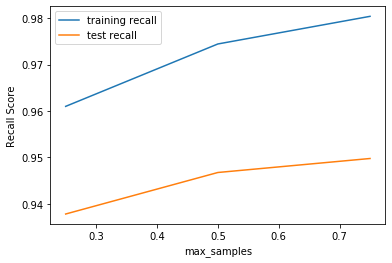

In [714]:
# PLot the score for train and test data
# plotting accuracies with n_estimators

col = 'max_samples'
plt.figure()
plt.plot(results["param_"+col], 
         results["mean_train_score"], 
         label="training recall")
plt.plot(results["param_"+col], 
         results["mean_test_score"], 
         label="test recall")
plt.xlabel(col)
plt.ylabel("Recall Score")
plt.legend()
plt.show()

In [718]:
#### Bring it all together
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'max_depth':[8,12,16],
            'n_estimators' : [200],
            'max_features' : [10,15,20],
            'min_samples_leaf' : [20,25,35],
            'max_samples':[0.25,0.50,0.75]}

rf = RandomForestClassifier(max_depth=12,random_state=100,n_jobs=-1,verbose=True)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal,y_train_bal)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend Th

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend Th

[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks   

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks   

[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | el

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | el

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.9s

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.5s

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend Th

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | el

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | e

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | 

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | el

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    4.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_job

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend Th

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tas

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=100,
                                     

In [727]:
# Store the cross validations results
results = pd.DataFrame(gs_rf.cv_results_)
results.sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
78      13.252330      0.573557         0.179118        0.048415   
51      11.684043      0.123705         0.184510        0.041532   
69       9.648696      0.069752         0.156621        0.048325   
60       6.631264      0.057183         0.186409        0.048673   
42       8.960929      0.138193         0.182382        0.047194   

   param_max_depth param_max_features param_max_samples  \
78              16                 20              0.75   
51              12                 20              0.75   
69              16                 15              0.75   
60              16                 10              0.75   
42              12                 15              0.75   

   param_min_samples_leaf param_n_estimators  \
78                     20                200   
51                     20                200   
69                     20                200   
60                     20                200   
42                     20                200   

                                               params  split0_test_score  \
78  {'max_depth': 16, 'max_features': 20, 'max_sam...           0.852246   
51  {'max_depth': 12, 'max_features': 20, 'max_sam...           0.855882   
69  {'max_depth': 16, 'max_features': 15, 'max_sam...           0.857180   
60  {'max_depth': 16, 'max_features': 10, 'max_sam...           0.857699   
42  {'max_depth': 12, 'max_features': 15, 'max_sam...           0.852766   

    split1_test_score  split2_test_score  split3_test_score  \
78           0.941589           0.951961           0.946248   
51           0.941329           0.949883           0.945728   
69           0.939512           0.947286           0.944170   
60           0.936137           0.945209           0.945728   
42           0.937954           0.947286           0.944690   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
78           0.946248         0.927658        0.037849                1   
51           0.945209         0.927606        0.035965                2   
69           0.944170         0.926464        0.034731                3   
60           0.940016         0.924958        0.033814                4   
42           0.942093         0.924958        0.036228                5   

    split0_train_score  split1_train_score  split2_train_score  \
78            0.955015            0.943521            0.941642   
51            0.955469            0.941574            0.939825   
69            0.954041            0.941184            0.939435   
60            0.952353            0.938977            0.937033   
42            0.952548            0.940600            0.939176   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
78            0.942811            0.942486          0.945095         0.004996  
51            0.941642            0.941837          0.944069         0.005746  
69            0.942227            0.941577          0.943693         0.005256  
60            0.939955            0.940149          0.941693         0.005443  
42            0.940019            0.939955          0.942459         0.005065

In [728]:
# Get the best parameters
gs_rf.best_params_

{'max_depth': 16,
 'max_features': 20,
 'max_samples': 0.75,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [730]:
# Get the best model
best_model_rf = gs_rf.best_estimator_
best_model_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=20,
                       max_leaf_nodes=None, max_samples=0.75,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=100,
                       verbose=True, warm_start=False)

In [731]:
# Predict on the fitted model 
y_test_pred_rf = best_model_rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [732]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred_rf))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      8237
         1.0       0.49      0.75      0.59       793

    accuracy                           0.91      9030
   macro avg       0.73      0.84      0.77      9030
weighted avg       0.93      0.91      0.92      9030



In [733]:
# Confusion Matrix
print(confusion_matrix(y_test,y_test_pred_rf))

[[7611  626]
 [ 201  592]]


In [734]:
# Compute accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred_rf)

0.9084163898117387

In [735]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred_rf)

0.7465321563682219

### 75% is a decent sensitivity/recall score for the dataset.

In [736]:
# Feature Imporatance interpretation
best_model_rf.feature_importances_

array([3.99152572e-03, 1.43743777e-02, 2.74080758e-01, 8.64232605e-02,
       1.10261272e-02, 5.32593062e-03, 3.28166963e-03, 2.98038220e-03,
       9.99398026e-03, 7.69027943e-04, 2.90263228e-03, 1.38498851e-03,
       3.81191603e-03, 2.34301399e-03, 6.48272606e-02, 4.36160343e-03,
       1.48513864e-03, 1.64763616e-03, 2.82566218e-03, 6.38573044e-04,
       4.00344207e-03, 1.45930349e-01, 2.24743056e-03, 1.60765490e-03,
       7.24531062e-04, 1.11029356e-02, 8.57789161e-02, 4.68495077e-02,
       6.07065115e-02, 4.74416821e-03, 4.95929954e-03, 3.20519426e-03,
       1.88069323e-03, 2.26978258e-03, 6.77521485e-05, 4.60395937e-03,
       1.00523394e-03, 3.20779674e-03, 2.18104955e-03, 3.16431346e-03,
       3.37802335e-03, 3.22208924e-03, 2.07515129e-03, 3.33095691e-03,
       1.98719353e-03, 3.84232447e-03, 6.16186208e-03, 1.73478163e-03,
       3.14157899e-03, 2.00240729e-03, 3.21191599e-03, 1.70611517e-03,
       1.23199185e-03, 2.86925755e-03, 2.41160705e-03, 2.58148339e-03,
      

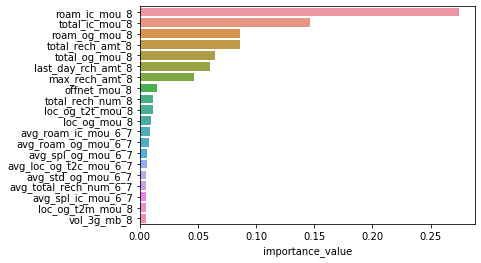

In [748]:
feature_imp = pd.DataFrame(best_model_rf.feature_importances_,columns=['importance_value'],index=X_train_bal.columns)
ax = sns.barplot(x='importance_value',y=feature_imp.sort_values(by='importance_value',ascending=False).head(20).index,data=feature_imp.sort_values(by='importance_value',ascending=False).head(20))
# ax.set_xlabel('importance_value')
# feature_imp.sort_values(by='importance_value').head(20).plot(kind='barh')

In [750]:
feature_imp.sort_values(by='importance_value',ascending=False).head(10)

importance_value
roam_ic_mou_8               0.274081
total_ic_mou_8              0.145930
roam_og_mou_8               0.086423
total_rech_amt_8            0.085779
total_og_mou_8              0.064827
last_day_rch_amt_8          0.060707
max_rech_amt_8              0.046850
offnet_mou_8                0.014374
total_rech_num_8            0.011103
loc_og_t2t_mou_8            0.011026

### The top features which determines a customer churn are below:
- roam_ic_mou_8
- total_ic_mou_8
- roam_og_mou_8
- total_rech_amt_8
- total_og_mou_8
- last_day_rch_amt_8

### Model for Prediction 

In [752]:
# Check the data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21068, 75)
(9030, 75)
(21068,)
(9030,)


In [755]:
# Check over-sampled data
print(X_train_bal.shape)
print(y_train_bal.shape)

(38512, 75)
(38512,)


In [756]:
# Scale the sampled data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_bal)

# Scale the train data
X_train_bal_scaled = scaler.transform(X_train_bal)


# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [758]:
X_train_bal_scaled.shape

(38512, 75)

In [760]:
X_test_scaled.shape

(9030, 75)

### Apply PCA

In [762]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='auto',random_state=100).fit(X_train_bal_scaled)


In [775]:
# Explained Variance by components
np.cumsum(pca.explained_variance_ratio_)

array([0.10417234, 0.18866408, 0.25011465, 0.30166361, 0.34965217,
       0.38608366, 0.42197824, 0.45432639, 0.4846273 , 0.51233552,
       0.5393157 , 0.56555433, 0.59096789, 0.61427879, 0.63446294,
       0.6536137 , 0.67104899, 0.68729281, 0.70301969, 0.71833083,
       0.73352329, 0.74802476, 0.76204645, 0.77508691, 0.78762446,
       0.79884789, 0.80985358, 0.8205289 , 0.83081533, 0.84065922,
       0.85046985, 0.85965944, 0.86796462, 0.87609123, 0.88400212,
       0.89162574, 0.89896576, 0.90625221, 0.91342548, 0.92047338,
       0.92651978, 0.9321521 , 0.93760356, 0.94200811, 0.94629904,
       0.95052805, 0.95464409, 0.95866824, 0.96224614, 0.96569654,
       0.96900646, 0.97221458, 0.97533145, 0.97836709, 0.98128461,
       0.98401742, 0.98670642, 0.98932668, 0.99179368, 0.99401021,
       0.99568612, 0.99690932, 0.9979994 , 0.99890589, 0.99919573,
       0.9994236 , 0.99959441, 0.99969579, 0.99978699, 0.99986408,
       0.99990501, 0.99993698, 0.99996749, 0.99998925, 1.     

Text(0.5, 0, 'Number of Principal components')

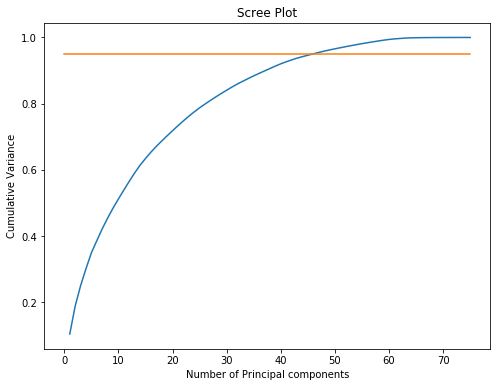

In [773]:
# Scree plot
plt.figure(figsize=(8,6))
sns.lineplot(range(1,76),np.cumsum(pca.explained_variance_ratio_))
plt.plot([0,75],[0.95,0.95])
plt.title('Scree Plot')
plt.ylabel('Cumulative Variance')
plt.xlabel('Number of Principal components')

### From the scree plot `45 pca components` describes 95% variance

In [776]:
# Final pca with 45 principal components
pca = PCA(n_components=45,svd_solver='auto',random_state=100).fit(X_train_bal_scaled)

In [777]:
# Apply pca on train dataset
X_train_bal_scaled_pca = pd.DataFrame(pca.transform(X_train_bal_scaled))
X_train_bal_scaled_pca.head()

0         1         2         3         4         5         6  \
0 -2.188023  0.090138 -0.137491  0.337795 -0.732937  0.636515  0.327336   
1  0.672879  8.420172  4.048385 -4.137789 -8.381590  1.392818  1.179911   
2  5.536369 -1.342551 -1.089542 -2.859008 -2.240253 -1.051825  0.235418   
3  1.014459 -0.687388 -2.032782 -0.360291  0.915326 -0.392572 -0.278513   
4  5.059886  9.861959 -2.636871 -3.381008  2.077061  2.193408 -1.441572   

          7         8         9        10        11        12        13  \
0  0.314238 -1.286561  0.325975 -0.997075 -0.368686  0.706983  0.233627   
1  1.763669  8.899263 -0.999689  0.963881  1.719492  0.488702 -3.530813   
2 -1.973660 -0.147432 -1.026828 -1.281239  0.748042  0.816173 -0.858789   
3 -0.353375  0.082114 -0.073650 -0.984381 -0.066925 -1.051465 -0.659342   
4 -2.545818 -0.020615 -1.635548  0.679908  3.715331 -1.913253 -0.745169   

         14        15        16        17        18        19        20  \
0 -0.635635 -0.161399  0.613116 -0.115902 -0.715204 -0.555579 -0.053551   
1  1.217053  3.037938  3.815790  0.108651  0.157855 -0.396220 -1.795670   
2 -1.246646  0.233708 -0.115001 -2.723609  0.125821  2.580356 -1.500899   
3 -0.294642  0.848189  0.564726  0.490760 -0.334789 -0.534172 -0.904635   
4  1.370240 -1.668771 -0.414387 -1.085733 -0.373021 -0.617601  0.692207   

         21        22        23        24        25        26        27  \
0  0.559277 -0.212228  0.165935  0.589984  0.161158  0.263863 -0.236110   
1  0.718426  0.749318  0.012845 -1.775897  0.356920 -4.521605 -2.417353   
2  0.651922 -0.478611 -0.120094 -0.261310  1.162272 -1.544909  0.287361   
3  0.426074  0.783782 -0.377222 -0.782710 -0.325473  0.158919 -0.560308   
4 -0.223263  0.071152 -0.549479 -0.120094  0.080223  0.404222  0.379302   

         28        29        30        31        32        33        34  \
0 -0.056374  0.397528  0.290414 -0.052490  0.127269  0.784183 -0.480693   
1 -2.795018  2.728810  1.024504 -4.788247  2.287523 -4.236464 -2.822825   
2  0.857608 -1.168039 -0.301384 -0.832678  0.428443 -0.674602  1.185222   
3 -0.790296 -0.237033  0.187972 -1.141287  0.433262 -1.049310  0.169898   
4 -0.600835 -0.663255 -0.347537  0.600085 -0.539550 -0.116906  0.413400   

         35        36        37        38        39        40        41  \
0 -0.094278  0.046364 -0.333884 -0.270900  0.260223 -0.166479  0.320311   
1 -2.444530 -0.940669  3.075485  2.072604 -1.590485 -1.637373 -0.157568   
2  0.383077  0.236632 -0.355820 -0.169211 -1.017336  0.193347 -0.419683   
3  0.500016  0.915434  0.324426  0.731945 -0.516035 -0.450917 -0.152322   
4  0.060576 -0.228520 -0.303962 -0.022062 -1.584771 -0.519661  0.533182   

         42        43        44  
0  0.144987 -0.018342  0.158448  
1 -5.764645 -0.202493  0.699882  
2  0.286341  0.446185  0.308966  
3  0.249575 -0.049300  0.234215  
4  0.535668 -0.280448 -0.561654

In [778]:
# Apply pca on train dataset
X_test_bal_scaled_pca = pd.DataFrame(pca.transform(X_test_scaled))
X_test_bal_scaled_pca.head()

0         1         2         3         4         5         6  \
0  2.092944 -0.929756 -2.255393 -0.062455  0.552876 -1.502953  0.153543   
1 -2.377027 -2.116575  0.306801 -0.344381 -0.849928 -0.148362 -1.100471   
2 -0.956293 -0.751921  1.329707 -1.650490 -3.130959 -0.333724  0.163361   
3 -0.131602 -1.475649 -0.689776  1.080566 -0.020612  0.024476  0.070457   
4  3.225776 -0.911175 -1.860594  0.744068  1.505238 -0.464086 -0.320238   

          7         8         9        10        11        12        13  \
0  0.007431 -0.239282 -0.256464 -0.363844 -1.122691  1.973654 -1.057828   
1 -0.668857  0.539693 -0.011135 -0.136844  0.031393 -0.285095  0.169148   
2  3.008466  2.208114  0.140787  2.035331 -3.254347 -3.635261  1.016905   
3  0.544077  0.210578 -0.119005 -1.002310  0.232259  0.313107  0.633347   
4 -0.089359 -0.304074 -0.626549 -1.202621  0.528576 -0.713258  0.397165   

         14        15        16        17        18        19        20  \
0 -1.462256  0.131230 -0.295239 -0.812871 -0.908805 -0.802610 -0.432856   
1  0.006343 -0.049365  1.068351  0.664795 -0.304183  0.113513 -0.579733   
2 -0.063352 -1.222236 -1.852957  0.800397 -1.966656 -0.925957  1.402734   
3  0.306762  0.090435 -1.043819 -0.154897 -0.002682 -0.526923 -0.317666   
4 -0.335899  1.093963 -1.428638 -0.762418 -0.078014 -1.008781 -1.107837   

         21        22        23        24        25        26        27  \
0  0.394219  0.532375 -1.614730  0.030686  0.577037  0.713310 -0.308502   
1  0.292590  0.423932 -0.201421 -0.309223 -0.226095 -0.418344 -0.111319   
2  0.221085  0.161342 -0.187866  0.073876  1.639342 -1.692007 -1.366899   
3 -0.060132  1.105399  0.847549 -0.260814 -0.243694 -0.036447 -0.391025   
4 -0.033835  1.010074  0.683005 -0.728116 -0.099325 -0.040071  0.133037   

         28        29        30        31        32        33        34  \
0  0.598579  0.020306  0.844346 -0.733939  0.176088  0.625727 -0.464567   
1 -1.127515  0.819872 -0.030217 -0.183600  0.914779 -1.667890 -0.291659   
2  0.895331 -0.252608  0.372506  0.398958 -0.520592  1.770844 -0.278689   
3 -0.393321 -0.511278 -0.307767  0.700584 -0.608242 -0.119715 -0.099141   
4 -0.855919 -0.206033  0.190240  0.530958  0.270967  0.080730  0.190444   

         35        36        37        38        39        40        41  \
0 -0.401202 -0.240869 -0.542111 -0.472122 -0.251255 -0.069387 -0.028853   
1  0.349498  1.122795  0.552726  0.133908 -0.291569 -0.123939 -0.348444   
2  0.269883 -0.829493  0.873075  0.924897 -0.085548  0.041054  0.061240   
3  0.555583  0.082013 -0.149743 -0.071020 -0.069779  0.372406 -0.043256   
4  0.162378  0.158885 -0.239936 -0.126209 -0.274689  0.408393  0.326811   

         42        43        44  
0  0.029308  0.118275  0.010955  
1  0.096894  0.443202  0.210736  
2 -0.120097  0.555399 -0.052556  
3  0.712110 -0.341313 -1.061727  
4 -0.070285  3.080404 -0.974050

In [779]:
print(X_train_bal_scaled_pca.shape)
print(X_test_bal_scaled_pca.shape)

(38512, 45)
(9030, 45)


### Logistic Regression Model

In [780]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model_lr = lr.fit(X_train_bal_scaled_pca,y_train_bal)

In [811]:
y_test_pred = model_lr.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [812]:
y_test_pred_prob = lr.predict_proba(X_test_bal_scaled_pca)
y_test_pred_prob = pd.DataFrame(y_test_pred_prob)
y_test_pred_prob.columns = ['zero','one']
y_test_pred_prob.one.head()

0    0.096351
1    0.885505
2    0.169419
3    0.317117
4    0.231494
Name: one, dtype: float64

In [813]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      8237
         1.0       0.31      0.81      0.45       793

    accuracy                           0.83      9030
   macro avg       0.65      0.82      0.68      9030
weighted avg       0.92      0.83      0.86      9030



In [814]:
# Confusion Matrix
print(confusion_matrix(y_test,y_test_pred))

[[6831 1406]
 [ 150  643]]


In [815]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.8108448928121059

### Base model provides a decent recall of 81 percent

In [807]:
# Tune the threshold value
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_test,y_test_pred_prob['one'])

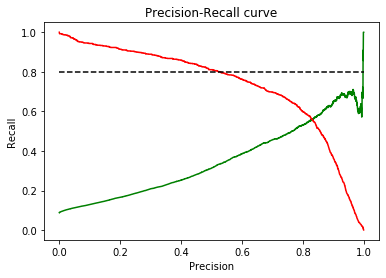

In [810]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.plot([0, 1], [0.8, 0.8], 'k--')
plt.title("Precision-Recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

### We can reduce the threshold to 0.4 to get a higher recall/sensitivity of 0.85

In [816]:
model_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [835]:
# Hyperparameter tuning using Grid serach cross validation for Logistic regression
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'C':[i/10 for i in range(1,11)],
          'penalty': ['l1','l2']}

lr = LogisticRegression(random_state=100)

# Grid Search
gs_lr = GridSearchCV(estimator=lr,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_lr.fit(X_train_bal_scaled_pca,y_train_bal)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=100, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                               1.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=0)

In [836]:
# Store the cross validations results
results = pd.DataFrame(gs_lr.cv_results_)
results.sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
9        0.140036      0.021791         0.007779        0.000978     0.5   
17       0.124517      0.020394         0.005983        0.003276     0.9   
15       0.116237      0.016590         0.006909        0.005006     0.8   
13       0.110251      0.009770         0.009041        0.006079     0.7   
11       0.113072      0.008804         0.007307        0.004957     0.6   

   param_penalty                       params  split0_test_score  \
9             l2  {'C': 0.5, 'penalty': 'l2'}           0.840821   
17            l2  {'C': 0.9, 'penalty': 'l2'}           0.840821   
15            l2  {'C': 0.8, 'penalty': 'l2'}           0.840821   
13            l2  {'C': 0.7, 'penalty': 'l2'}           0.840821   
11            l2  {'C': 0.6, 'penalty': 'l2'}           0.840821   

    split1_test_score  split2_test_score  split3_test_score  \
9            0.836968           0.846274           0.848091   
17           0.836968           0.846274           0.848091   
15           0.836968           0.846274           0.848091   
13           0.836968           0.846274           0.848091   
11           0.836968           0.846274           0.848091   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
9            0.837445          0.84192        0.004534                1   
17           0.837445          0.84192        0.004534                1   
15           0.837445          0.84192        0.004534                1   
13           0.837445          0.84192        0.004534                1   
11           0.837445          0.84192        0.004534                1   

    split0_train_score  split1_train_score  split2_train_score  \
9             0.843363            0.842508            0.841740   
17            0.843363            0.842508            0.841740   
15            0.843363            0.842508            0.841805   
13            0.843363            0.842508            0.841740   
11            0.843363            0.842508            0.841740   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
9             0.841610            0.843038          0.842452         0.000692  
17            0.841675            0.843038          0.842465         0.000676  
15            0.841675            0.843038          0.842478         0.000663  
13            0.841675            0.843038          0.842465         0.000676  
11            0.841675            0.843038          0.842465         0.000676

In [837]:
# Best params
gs_lr.best_params_

{'C': 0.2, 'penalty': 'l2'}

In [838]:
# Best estimator
best_lr_model = gs_lr.best_estimator_
best_lr_model

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [839]:
# Prediction on best model
y_test_pred = best_lr_model.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [847]:
y_test_pred_prob = best_lr_model.predict_proba(X_test_bal_scaled_pca)
y_test_pred_prob = pd.DataFrame(y_test_pred_prob)
y_test_pred_prob.columns = ['zero','one']
y_test_pred_prob.one.head()

0    0.096512
1    0.885324
2    0.169622
3    0.317256
4    0.231202
Name: one, dtype: float64

In [840]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      8237
         1.0       0.31      0.81      0.45       793

    accuracy                           0.83      9030
   macro avg       0.65      0.82      0.68      9030
weighted avg       0.92      0.83      0.86      9030



In [854]:
from sklearn.metrics import roc_curve,roc_auc_score
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

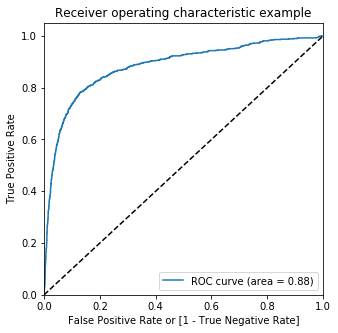

In [855]:
# Draw ROC Curve
draw_roc(y_test,y_test_pred_prob['one'])

In [842]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.8108448928121059

In [844]:
# Compute accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.8276854928017718

### Best Model for Logistic regression provides an recall of 81 percent

## SVM Classifier

In [888]:
# Fit a svm classifier
from sklearn.svm import SVC

svc = SVC().fit(X_train_bal_scaled_pca,y_train_bal)

In [889]:
svc

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [862]:
# Prediction on best model
y_test_pred = svc.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [863]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      8237
         1.0       0.38      0.73      0.50       793

    accuracy                           0.87      9030
   macro avg       0.68      0.81      0.71      9030
weighted avg       0.92      0.87      0.89      9030



In [864]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.7313997477931904

In [865]:
#Base model recall score is 73

In [895]:
# Hyperparameter tuning using Grid search cross validation for SVM
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'kernel' : ['linear','rbf'],
          'C' : [0.1, 1, 10, 100]}

svc = SVC(random_state=100)

# Grid Search
gs_svc = GridSearchCV(estimator=svc,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_svc.fit(X_train_bal_scaled_pca,y_train_bal)

In [896]:
# Store the cross validations results
results = pd.DataFrame(gs_svc.cv_results_)

In [870]:
# Best estimator
best_svm_model = gs_svc.best_estimator_ 
best_svm_model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)

In [890]:
# Prediction on best model
y_test_pred = best_svm_model.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [891]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

In [892]:
# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      8237
         1.0       0.38      0.73      0.50       793

    accuracy                           0.87      9030
   macro avg       0.68      0.81      0.71      9030
weighted avg       0.92      0.87      0.89      9030



In [893]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.7313997477931904

In [894]:
# Compute accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.8728682170542635

## Random Forest Classifier

In [873]:
# Fit a random forest classifier
rf = RandomForestClassifier(max_depth=12,random_state=100,n_jobs=-1,verbose=True)

In [874]:
rf.fit(X_train_bal_scaled_pca,y_train_bal)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=100,
                       verbose=True, warm_start=False)

In [875]:
# Prediction on best model
y_test_pred = rf.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [876]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      8237
         1.0       0.40      0.67      0.50       793

    accuracy                           0.88      9030
   macro avg       0.68      0.79      0.72      9030
weighted avg       0.92      0.88      0.89      9030



In [878]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.6708701134930644

In [879]:
# Compute accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.881063122923588

In [ ]:
#### Bring it all together
# Hyperparameter tuning using Grid serach cross validation
from sklearn.model_selection import GridSearchCV

# Grid search parameters
folds=5
params = {'max_depth':[8,12,16],
            'n_estimators' : [200],
            'max_features' : [10,15,20],
            'min_samples_leaf' : [20,25,35],
            'max_samples':[0.25,0.50,0.75]}

rf = RandomForestClassifier(max_depth=12,random_state=100,n_jobs=-1,verbose=True)

# Grid Search
gs_rf = GridSearchCV(estimator=rf,param_grid=params,scoring='recall',cv=folds,return_train_score=True)
gs_rf.fit(X_train_bal_scaled_pca,y_train_bal)

In [887]:
best_rf_model = gs_rf.best_estimator_

In [883]:
# Prediction on best model
y_test_pred = best_rf_model.predict(X_test_bal_scaled_pca)
pd.DataFrame(y_test_pred).head()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


0
0  0.0
1  1.0
2  0.0
3  0.0
4  0.0

In [884]:
# Evaluate the model
from sklearn.metrics import classification_report,confusion_matrix

# Get classification results
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      8237
         1.0       0.38      0.70      0.49       793

    accuracy                           0.87      9030
   macro avg       0.67      0.79      0.71      9030
weighted avg       0.92      0.87      0.89      9030



In [885]:
# Compute recall score
from sklearn.metrics import recall_score,accuracy_score
recall_score(y_test,y_test_pred)

0.7011349306431274

In [886]:
# Compute accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.8719822812846069

# Conclusion and Recommendations

- `Recall/Sensitivity` is the best model evaluation metric
- `Logistic Regression` is the best model with a recall of more than 80%. The sensitivity/recall can further increased by decreasing the threshold.
- From our Model Feature Importance and EDA we can see the below:-


- The following parameters when increases leads to churn


**1.avg_roam_og_mou_6_7
  2.avg_std_og_mou_6_7
  3.roam_ic_mou_8 
  4.roam_og_mou_8**

- The following parameters when increasing shows a happy customer

**1.total_ic_mou_8 
  2.total_rech_amt_8 
  3.total_og_mou_8 
  4.last_day_rch_amt_8 
  5.aon(Tenure)**


### Recommendation for the company: 
- The should focus on customers who are using more roaming try to provide them good roaming packs in for discounted price
- They should try to increase tenure of a client with the company by providing good service.


